In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Dropout,
)
import pickle 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import shap

Consruct emotion model, download and load weights (Emotion.py in Deepface)

In [2]:
input_dim_ = 64

In [3]:
num_classes = 2

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(input_dim_, input_dim_, 1)))
# model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
# model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# fully connected neural networks
# model.add(Dense(1024, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(1024, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Metal device set to: Apple M2


2024-06-10 18:58:27.957022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 18:58:27.957309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 128)      0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 2)                 3

In [5]:
model.load_weights('polish_confusion_weights.h5')

In [6]:
# load pickle file
files = ['Polish_Dataset.pkl']
# files = ['Eastern_Asian_Dataset.pkl']
x_train_list = []
y_train_list = [] 
for file in files:
    with open(file, 'rb') as f:
        features, labels = pickle.load(f)
    
    for pic, label in zip(features, labels):
        # plt.imshow(img_gray, cmap='binary_r')
        x_train_list.append(pic)
        y_train_list.append(label)

In [7]:
X_train = np.array(x_train_list).reshape(-1, input_dim_, input_dim_, 1)
#one-hot encode target column
Y_train = to_categorical(np.array(y_train_list))

In [8]:
Y_train[500].argmax()

1

In [9]:
np.unique(Y_train.argmax(axis=1), return_counts=True)

(array([0, 1]), array([2839, 6888]))

In [10]:
indices = [np.where(Y_train.argmax(axis=1)==i)[0] for i in np.unique(Y_train.argmax(axis=1))]
indices

[array([1749, 1750, 1751, ..., 8174, 8175, 8176]),
 array([   0,    1,    2, ..., 9724, 9725, 9726])]

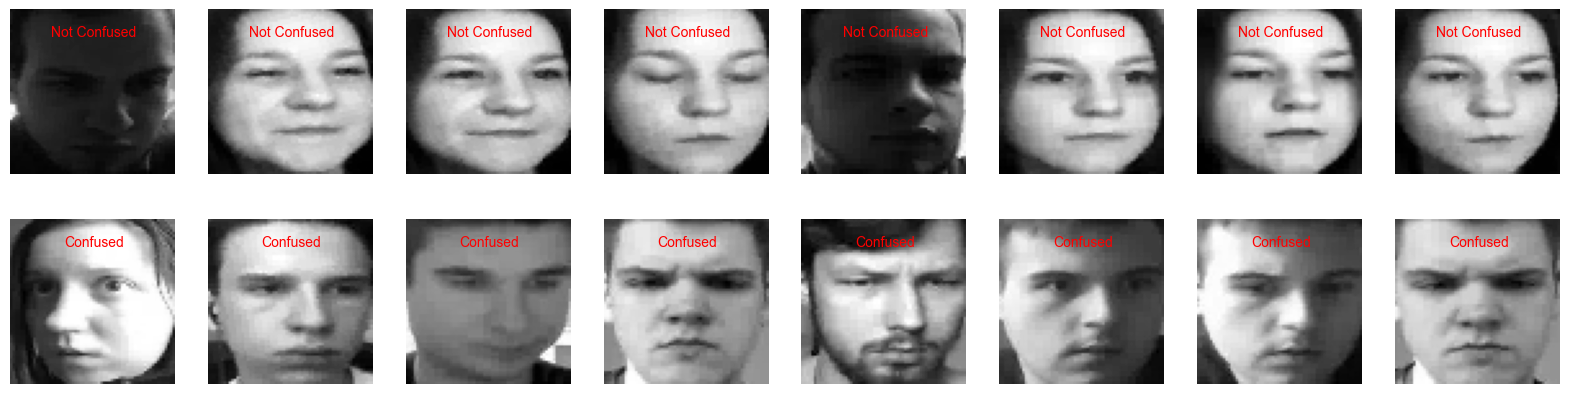

In [11]:
label_names = ['Not Confused', 'Confused']
rows = 2
cols = 8
# num_to_choose = int(rows*cols)
# np.random.seed(42)
# chosen_nums = np.random.choice(np.arange(len(X_train)), size=num_to_choose, replace=False)
fig, ax = plt.subplots(rows, cols, figsize=(20, 5), sharex=True, sharey=True)

for row in range(rows):
    np.random.seed(35)
    # num_to_choose = int(rows*cols)
    chosen_nums = np.random.choice(indices[row], size=cols, replace=False)
    count = 0
    for col in range(cols):
        ax[row, col].imshow(X_train[chosen_nums[count]], cmap='binary_r')
        ax[row, col].text(32, 10, label_names[Y_train[chosen_nums[count]].argmax()], 
                          horizontalalignment='center', color='r')
        count += 1
        
        ax[row, col].axis('off')

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
x_train.shape, x_test.shape

((7781, 64, 64, 1), (1946, 64, 64, 1))

In [13]:
background_num = 300
sample_num = 10
np.random.seed(42)
desired_label = 1
background = x_train[np.random.choice(x_train.shape[0], background_num, replace=False)]
test_images = x_test[np.random.choice(np.where(y_test.argmax(axis=1) == desired_label)[0], sample_num, replace=False)]

In [14]:
e = shap.DeepExplainer(model, background)

/Users/lucia/miniconda3/envs/edusense_cnn_39/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [15]:
shap_values = e.shap_values(test_images, check_additivity=False)

/Users/lucia/miniconda3/envs/edusense_cnn_39/lib/python3.9/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2024-06-10 18:58:39.343162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-10 18:58:39.345621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit flo

In [16]:
shap_vals = [shap_values[:, :, :, :, i] for i in range(shap_values.shape[-1])]

In [17]:
index_names = np.tile(label_names, len(test_images)).reshape(-1, 2)

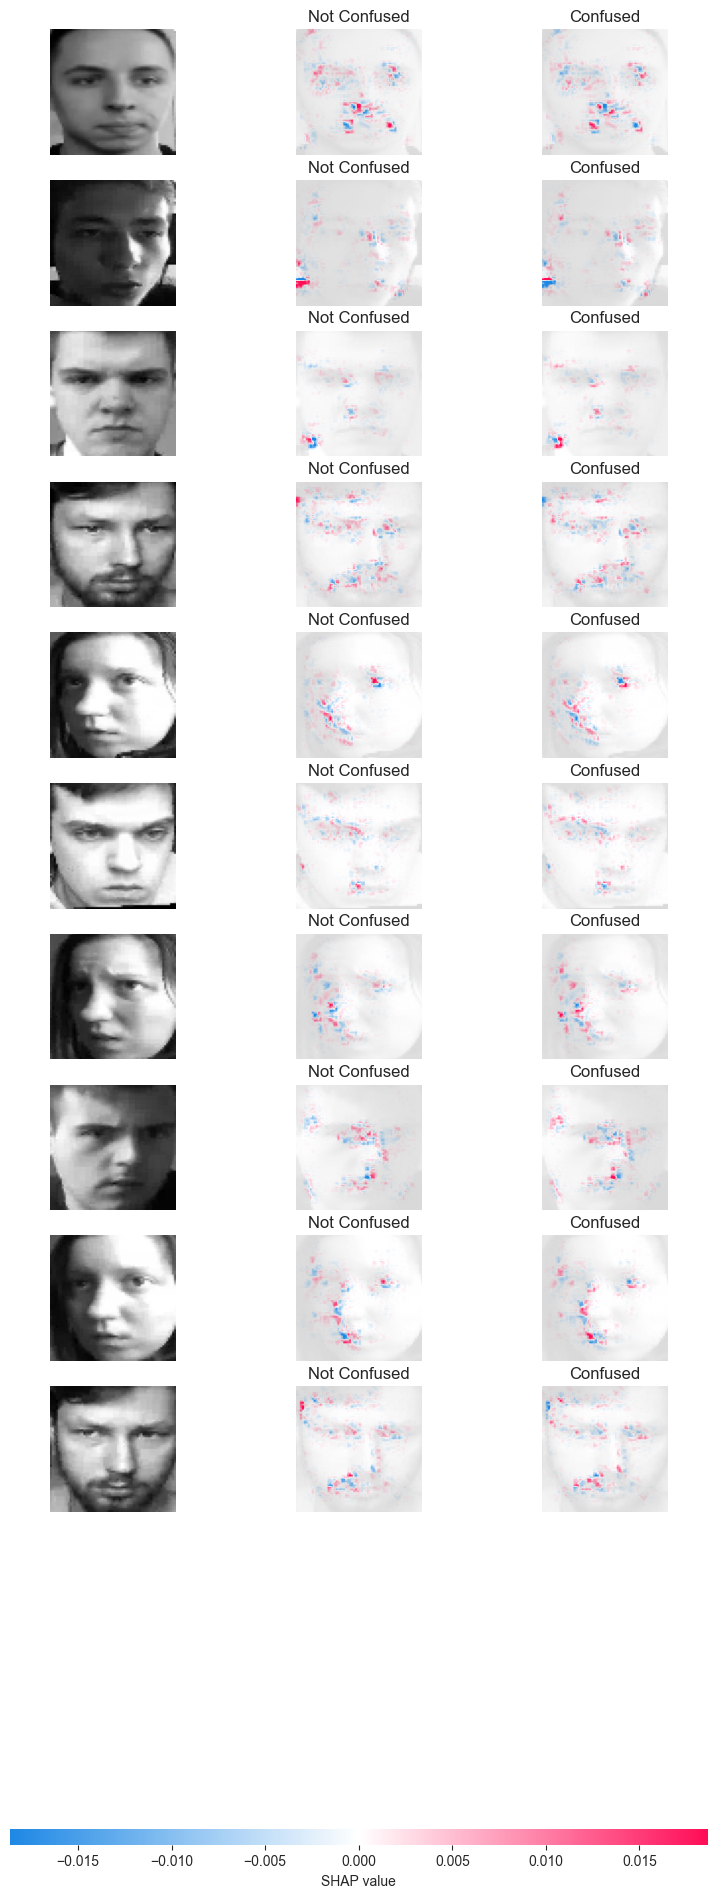

In [18]:
shap.image_plot(shap_vals, 
                test_images, 
                index_names, 
                show=False,
                )
# plt.savefig('SHAP_Polish.svg', bbox_inches='tight', dpi=300)

In [68]:
len(shap_vals)

2

In [19]:
with open('SHAP_values_Polish', 'wb') as f:
    pickle.dump(shap_vals, f)

<AxesSubplot: xlabel='y', ylabel='count'>

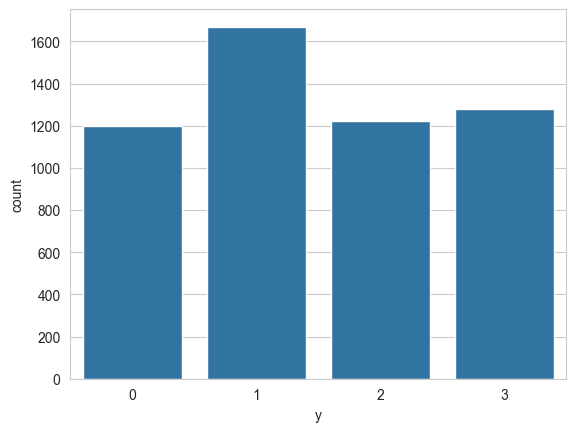

In [44]:
df = pd.DataFrame({'y': y_test_list})
sns.countplot(data=df, x='y')

<AxesSubplot: xlabel='y', ylabel='count'>

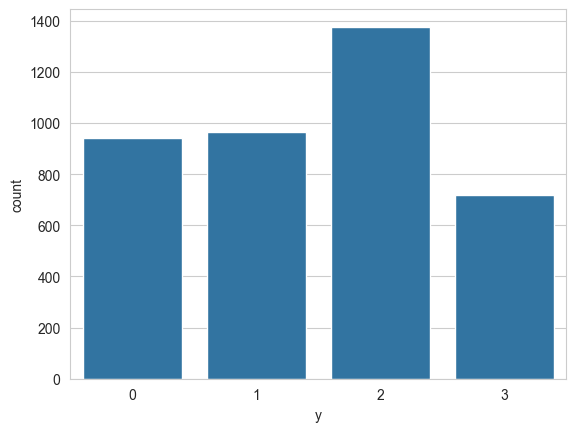

In [45]:
df = pd.DataFrame({'y': y_valid_list})
sns.countplot(data=df, x='y')

In [46]:
np.array(y_train_list).shape

(15255,)

In [73]:
from tensorflow.keras.utils import to_categorical
#one-hot encode target column
Y_train = to_categorical(np.array(y_train_list))
Y_test = to_categorical(np.array(y_test_list))
Y_validation = to_categorical(np.array(y_valid_list))
Y_train[200]

array([0., 1., 0., 0.], dtype=float32)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((12204, 128, 128, 1), (3051, 128, 128, 1))

In [81]:
model.fit(x_train, y_train, epochs=30)

Epoch 1/30


2024-05-19 21:02:59.502562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 55s 143ms/step - loss: 5.2598 - accuracy: 0.5629
Epoch 2/30
382/382 [==============================] - 51s 134ms/step - loss: 0.6590 - accuracy: 0.7373
Epoch 3/30
382/382 [==============================] - 54s 140ms/step - loss: 0.5048 - accuracy: 0.8017
Epoch 4/30
 31/382 [=>............................] - ETA: 56s - loss: 0.3475 - accuracy: 0.8609

KeyboardInterrupt: 

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      1664      
                                                                 
 conv2d_15 (Conv2D)          (None, 122, 122, 32)      18464     
                                                                 
 flatten_4 (Flatten)         (None, 476288)            0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1905156   
                                                                 
Total params: 1,925,284
Trainable params: 1,925,284
Non-trainable params: 0
_________________________________________________________________


In [82]:
prediction_proba = model.predict(x_test)
y_predict = prediction_proba.argmax(axis=1)

 2/96 [..............................] - ETA: 7s 

2024-05-19 21:05:49.043001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 2s 24ms/step


In [83]:
y_predict.shape

(3051,)

In [84]:
y_true = y_test.argmax(axis=1)

In [85]:
# y_true = np.array(y_test_list)

In [86]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_predict, normalize='true')

<AxesSubplot: >

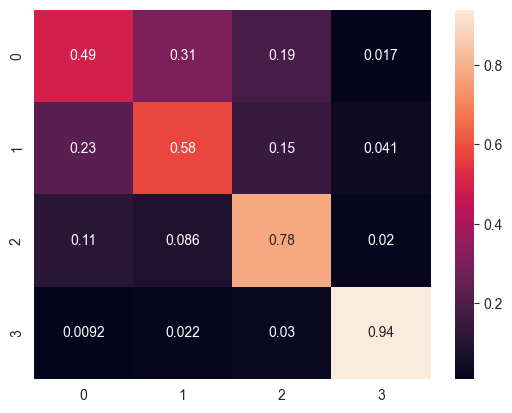

In [87]:
sns.heatmap(conf_mat, annot=True)